Playing with chunking/embedding code from https://huggingface.co/learn/cookbook/advanced_rag on PythonDSHandbook.txt, Week7-lecture.txt, Week9-lecture.txt

In [1]:
# import packages

from tqdm.notebook import tqdm #progress bar
import pandas as pd
from typing import Optional, List, Tuple #type hinting
# from datasets import Dataset #to load in premade example datasets
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

from langchain_text_splitters import RecursiveCharacterTextSplitter #splitter

#langsmith setup
import os
import dotenv
dotenv.load_dotenv()

#load in Documents
from langchain.docstore.document import Document as LangchainDocument
# from langchain.text_splitter import RecursiveCharacterTextSplitter #alt import
from langchain_community.document_loaders import DirectoryLoader

from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer

# embedding and searching
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

#plotting
import pacmap
import numpy as np
import plotly.express as px

In [2]:
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

In [3]:
## load in docs (must be in IA-in-HigherEd dir)
loader = DirectoryLoader('./RAG-docs/processed/', glob="**/*.txt", show_progress = True) #all .txt files in processed folder
docs = loader.load()
docs

# save as LC docs
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc.page_content, metadata= doc.metadata) for doc in tqdm(docs)]

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


  0%|          | 0/10 [00:00<?, ?it/s]

c:\Users\wat6sv\AppData\Local\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Model's maximum sequence length: 384


Token indices sequence length is longer than the specified maximum sequence length for this model (516 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/1517 [00:00<?, ?it/s]

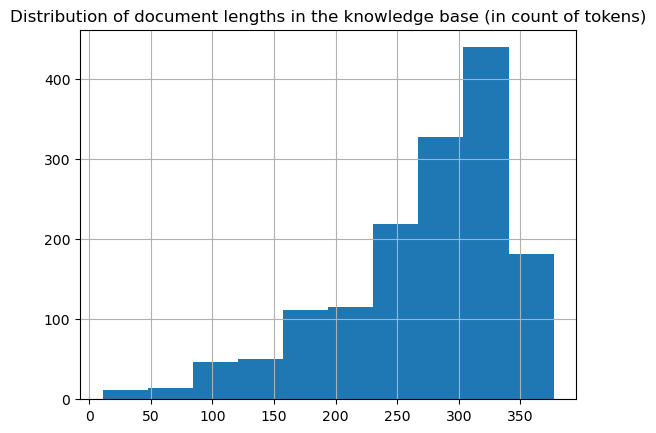

In [4]:
# split (chunk) docs with chunk size = max seq length()

EMBEDDING_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"

seq_len = SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length
print(f"Model's maximum sequence length: {seq_len}")


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    seq_len,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

In [5]:
# create embeddings for docs 
## Takes a while to run loacally (~6 min w/ PythonDS, Week7, Week9)


embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    # model_kwargs={"device": "cuda"}, #using cpu when running locally - change if connecting to GPU for more speed
    encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
)

#edit distance strategy for use case
KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

In [6]:
#try chroma for vector storage


# from langchain_community.vectorstores import Chroma

# text_splitter  = RecursiveCharacterTextSplitter(chunk_size=seq_len,chunk_overlap=20)
# text_chunks = text_splitter.split_documents(RAW_KNOWLEDGE_BASE)


# vectorstore = Chroma.from_documents(documents=text_chunks, 
#                                     embedding=embedding_model)#,
#                                     # persist_directory="data/vectorstore")

In [7]:
# sim_docs = vectorstore.similarity_search("What is a decision tree?")

In [8]:
# for doc in sim_docs:
#     print(doc.metadata['source'], "\n", doc.page_content, "\n\n\n")

In [9]:
KNOWLEDGE_VECTOR_DATABASE.save_local("faiss_index")

In [12]:
# Embed a user query in the same space
user_query = "What is a decision tree?"
query_vector = embedding_model.embed_query(user_query)

In [13]:
# create pca projection of embeddings for visualization

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0]) for idx in range(len(docs_processed))
] + [query_vector]

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

In [14]:
# vistualize pca projection

df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"],#["source"],#.split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# Visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()